# Step Detection

## Loading data

In [25]:
from datahandler.data_loader import load_data_from_file, load_date_from_steptracking_file
from datahandler.constants import v4_walking, v4_mix
import os
from utils import print_line_divider
from datetime import timedelta
import pandas as pd
import numpy as np
from random import random, seed
from sklearn.preprocessing import MinMaxScaler

seed(100)
location_labels = ['holdinginhand', 'insidethebag', 'insidethepantpocket']

#### Load file names

In [26]:
# Loading file names
data_folder = v4_mix


def get_all_files_from_folder(folder):
    file_names = []
    for datafile in os.listdir(folder):
        if datafile.startswith("."):
            continue

        path = os.path.join(folder, datafile)
        if os.path.isfile(path):
            file_names.append(datafile)
    return file_names


data_dict = {}
for filename in get_all_files_from_folder(data_folder):
    code = filename[:3]
    data_dict[code] = os.path.join(data_folder, filename)

step_dict = {}
for filename in get_all_files_from_folder(data_folder + "/step_fixed"):
    code = filename[:3]
    if code in data_dict.keys():
        step_dict[code] = os.path.join(data_folder, "step", filename)

print(step_dict.keys())

dict_keys(['ds5', 'mm3', 'pp1', 'tt3', 'ds4', 'pp5', 'ds3', 'mm5', 'mm4', 'tt1', 'pp3', 'tt5'])


In [27]:
# Configuration
WINDOW_SIZE = 40
WINDOW_LENGTH_IN_SECONDS = 2

#### Load data from one file pair

## Building model & configuration

In [28]:
def load_data_from_code(code):
    # Step 1
    df = load_data_from_file(data_dict[code])
    df = df.drop("labelActivity", axis=1)
    df['labelPhone'] = df['labelPhone'].apply(lambda x: location_labels.index(x))
    # Step 2
    step_dates = load_date_from_steptracking_file(step_dict[code])
    # Step 3
    fixed_size_data = []
    fixed_size_indexes = []
    current_timestamp = df.index[0].to_pydatetime()
    last_timestamp_raw = df.index[df.shape[0] - 1].to_pydatetime()
    current_timestamp_raw_index = 0
    one_window_length_in_millis = WINDOW_LENGTH_IN_SECONDS * 1000 / WINDOW_SIZE
    while True:
        current_timestamp = current_timestamp + timedelta(milliseconds=one_window_length_in_millis)
        if current_timestamp > last_timestamp_raw:
            break

        while current_timestamp_raw_index < df.shape[0] - 1:
            next_timestamp_raw = df.index[current_timestamp_raw_index + 1].to_pydatetime()
            if next_timestamp_raw < current_timestamp:
                current_timestamp_raw_index += 1
            else:
                break

        fixed_size_data.append(df.iloc[current_timestamp_raw_index])
        fixed_size_indexes.append(current_timestamp)
    fixed_size_df = pd.DataFrame(
        data=fixed_size_data,
        index=fixed_size_indexes,
        columns=df.columns
    )

    # Step 4
    def update_date_microsecond(date, first_rem, second_rem):
        current_microsecond = date.microsecond
        new_microsecond_one = (int(current_microsecond / 100000) * 100 + first_rem) * 1000
        new_microsecond_two = (int(current_microsecond / 100000) * 100 + second_rem) * 1000
        diff_one = abs(current_microsecond - new_microsecond_one)
        diff_two = abs(current_microsecond - new_microsecond_one)
        if diff_one > diff_two:
            new_microsecond = new_microsecond_two
        else:
            new_microsecond = new_microsecond_one
        return date.replace(microsecond=new_microsecond)

    index_first_date = fixed_size_df.index[0]
    milli = index_first_date.microsecond / 1000
    first_remainder = int(milli % 100)
    second_remainder = int((milli + 50) % 100)

    updated_step_dates = set()
    for date in step_dates:
        updated_step_dates.add(update_date_microsecond(date, first_remainder, second_remainder))

    is_step_series = []
    count = 0
    for m in fixed_size_df.index:
        is_step = m.to_pydatetime() in updated_step_dates
        if is_step:
            count += 1
        is_step_series.append(is_step)

    fixed_size_df['isStep'] = is_step_series

    # Step 5
    def normalize(df):
        feature_count = df.shape[1] - 2
        values = df.iloc[:, 0:feature_count]
        phone_labels = df.loc[:, "labelPhone"].set_axis(range(df.shape[0]))
        is_step = df.loc[:, "isStep"].set_axis(range(df.shape[0]))
        normalizer = MinMaxScaler()
        normalized_values = normalizer.fit_transform(values)
        normalized_df = pd.DataFrame(
            data=normalized_values,
            columns=values.columns
        )
        normalized_df["labelPhone"] = phone_labels
        normalized_df["isStep"] = is_step
        return normalized_df

    normalized_df = normalize(fixed_size_df)

    # Step 6
    def count_number_of_steps(list):
        step_count = 0
        for item in list:
            if item:
                step_count += 1
        return step_count

    def convert_df_to_final_train_data(df):

        train_x, test_x = [], []
        train_y_context, test_y_context = [], []
        train_y_step, test_y_step = [], []

        window_index_start = 0
        window_index_increasing_size = int(WINDOW_SIZE / 8)  # 2
        no_features = df.shape[1] - 2
        values = df.iloc[:, 0:no_features]
        context_labels = df.loc[:, "labelPhone"]
        step_found = df.loc[:, "isStep"]

        while window_index_start + WINDOW_SIZE < df.shape[0]:
            train_data = values[window_index_start:(window_index_start + WINDOW_SIZE)]
            context_label = context_labels[window_index_start]
            step_count = count_number_of_steps(step_found[window_index_start:(window_index_start + WINDOW_SIZE)])

            if random() < 0.15:
                test_x.append(train_data)
                test_y_context.append(context_label)
                test_y_step.append(step_count)
            else:
                train_x.append(train_data)
                train_y_context.append(context_label)
                train_y_step.append(step_count)

            window_index_start += window_index_increasing_size

        return train_x, train_y_step, train_y_context, test_x, test_y_step, test_y_context

    return convert_df_to_final_train_data(normalized_df)


In [29]:
train_x, train_y_step, train_y_context = [], [], []
test_x, test_y_step, test_y_context = [], [], []

# mm, tt, pp, ds, os
inside_pant_pocket = ["tt1", "pp1", "ds4"]  # 75%
inside_the_bag = ["tt5", "pp5", "ds3"]
swinging_in_hand = ["tt3", "pp3", "ds5"]
all_data = inside_pant_pocket + inside_the_bag + swinging_in_hand
for code in all_data:
    print("Handling data from code " + code)
    a, c, d, e, g, h = load_data_from_code(code)

    train_x = train_x + a
    train_y_step = train_y_step + c
    train_y_context = train_y_context + d
    test_x = test_x + e
    test_y_step = test_y_step + g
    test_y_context = test_y_context + h

train_x = np.array(train_x)
train_y_step = np.array(train_y_step)
train_y_context = np.array(train_y_context)
test_x = np.array(test_x)
test_y_step = np.array(test_y_step)
test_y_context = np.array(test_y_context)

print_line_divider()
print(train_x.shape, train_y_step.shape, train_y_context.shape)
print(test_x.shape, test_y_step.shape, test_y_context.shape)

Handling data from code tt1
Handling data from code pp1
Handling data from code ds4
Handling data from code tt5
Handling data from code pp5
Handling data from code ds3
Handling data from code tt3
Handling data from code pp3
Handling data from code ds5
****************************************************
(9167, 40, 9) (9167,) (9167,)
(1626, 40, 9) (1626,) (1626,)


## Training and testing

#### Simple binary classifier using CNN

In [26]:
from keras import layers, models, Sequential
from models.log_writer import LogWriter

log_writer = LogWriter(enabled=True)


def build_shallow_cnn(input_shape):
    model_2d = Sequential()
    model_2d.add(
        layers.Conv1D(
            filters=12,
            kernel_size=3,
            strides=1,
            padding="same",
            activation='relu',
            input_shape=input_shape)
    )
    model_2d.add(layers.Dropout(0.1))
    model_2d.add(layers.MaxPooling1D(pool_size=2, strides=2, padding="valid"))
    model_2d.add(layers.Flatten())
    model_2d.add(layers.Dense(50, activation='relu'))
    model_2d.add(layers.Dropout(0.4))
    model_2d.add(layers.Dense(1, activation='relu'))
    return model_2d


def build_cnn_step_model(input_shape):
    input_layer = layers.Input(input_shape)
    conv1 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)
    conv2 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)
    conv3 = layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv2)
    conv3 = layers.ReLU()(conv1)
    gap = layers.GlobalAveragePooling1D()(conv2)
    dense = layers.Dense(128, activation='relu')(gap)
    output_layer = layers.Dense(1, activation="relu")(dense)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = build_cnn_step_model((40, 9))
# model = build_shallow_cnn((40,9))
model.summary()
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
log_writer.write("Model Configuration", line_divider=True)
log_writer.write(short_model_summary)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 9)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 40, 64)            1792      
                                                                 
 batch_normalization_6 (Batc  (None, 40, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 40, 64)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 40, 64)            12352     
                                                                 
 batch_normalization_7 (Batc  (None, 40, 64)           256       
 hNormalization)                                           

In [27]:
from keras import callbacks
import tensorflow as tf
from time import time
from audio.audio import play_training_is_complete

SAVED_BEST_MODEL = "model/best_step_model.h5"
reduce_lr_patience = 30
early_stopping_patience = 150
callback_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=reduce_lr_patience, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, verbose=1),
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss")
]
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
epochs = 300
batch_size = 32
validation_split = 15 / 85
adam_starting_lr = 0.005
optimizer = tf.keras.optimizers.Adam(
    learning_rate=adam_starting_lr,
    name="Adam",
)

loss_function = "mse"
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    # metrics=['accuracy']
)

log_writer.write(
    f"""Epoch: {epochs}
Batch size: {batch_size}
Validation split: {validation_split}
Optimizer: Adam with starting lr {adam_starting_lr}
Loss function: {loss_function}
Reduce LR patience: {reduce_lr_patience}
Early stopping patience: {early_stopping_patience}
"""
)
log_writer.write("Data Configuration", line_divider=True)
log_writer.write(
    f"""Data training shape: ${train_x.shape}
Data testing shape: ${test_x.shape}"""
)
start_time = time()
history = model.fit(
    train_x,
    train_y_step,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
end_time = time()
training_time = end_time - start_time
log_writer.write("Result", line_divider=True)
log_writer.write("Training time: " + str(end_time - start_time) + " seconds.")
log_writer.write("Smallest validation loss: " + str(min(history.history['val_loss'])))
model = models.load_model(SAVED_BEST_MODEL)
play_training_is_complete()

Epoch 1/300
236/236 [==============================] - 3s 10ms/step - loss: 0.8571 - val_loss: 1.9659 - lr: 0.0050
Epoch 2/300
236/236 [==============================] - 1s 6ms/step - loss: 0.6733 - val_loss: 1.1174 - lr: 0.0050
Epoch 3/300
236/236 [==============================] - 2s 7ms/step - loss: 0.6150 - val_loss: 1.4433 - lr: 0.0050
Epoch 4/300
236/236 [==============================] - 2s 7ms/step - loss: 0.6078 - val_loss: 1.3773 - lr: 0.0050
Epoch 5/300
236/236 [==============================] - 2s 8ms/step - loss: 0.5777 - val_loss: 0.9599 - lr: 0.0050
Epoch 6/300
236/236 [==============================] - 2s 8ms/step - loss: 0.5521 - val_loss: 1.2816 - lr: 0.0050
Epoch 7/300
236/236 [==============================] - 2s 9ms/step - loss: 0.5422 - val_loss: 1.9329 - lr: 0.0050
Epoch 8/300
236/236 [==============================] - 2s 9ms/step - loss: 0.5223 - val_loss: 1.5161 - lr: 0.0050
Epoch 9/300
236/236 [==============================] - 2s 8ms/step - loss: 0.5230 - val

Input #0, wav, from '/var/folders/ph/8yv0q18n4mb1439tnf3rzcf40000gp/T/tmpl0i72jd1.wav':
  Duration: 00:00:02.27, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s


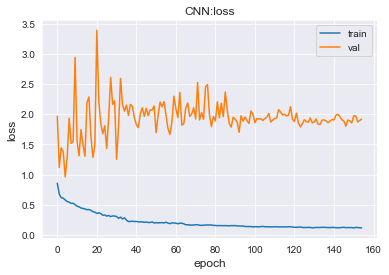

In [28]:
import matplotlib.pyplot as plt

# Plot the result
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("CNN:" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

In [29]:
def round_pred(pred):
    round_list = []
    for i in pred:
        round_list.append(round(i[0]))
    return round_list


def print_correct_count(pred, actual, log):
    old_pred = pred
    pred = round_pred(pred)
    correct_count = 0
    diff_list = []
    for i in range(len(actual)):
        diff_list.append(abs(actual[i] - pred[i]))
        if actual[i] == pred[i]:
            print("Correct: ", pred[i])
            correct_count += 1
        else:
            print("Incorrect: index - ", i, " | base - ", old_pred[i][0], " | predict - ", pred[i], " | actual - ",
                  actual[i])
    print("Correct: ", correct_count, "/", len(actual))
    log.write("Correct " + str(correct_count) + "/" + str(len(actual)))

    log.write("Mean difference: " + str((sum(diff_list) / len(diff_list))))


y_pred = model.predict(test_x)
print_correct_count(y_pred, test_y_step, log_writer)

log_writer.close()
print_line_divider()


Correct:  2
Incorrect: index -  1  | base -  2.3244262  | predict -  2  | actual -  3
Incorrect: index -  2  | base -  2.1492522  | predict -  2  | actual -  3
Correct:  3
Correct:  3
Incorrect: index -  5  | base -  2.8574624  | predict -  3  | actual -  2
Correct:  3
Incorrect: index -  7  | base -  2.5608625  | predict -  3  | actual -  2
Incorrect: index -  8  | base -  2.4535542  | predict -  2  | actual -  3
Correct:  3
Incorrect: index -  10  | base -  2.6161985  | predict -  3  | actual -  4
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Incorrect: index -  17  | base -  3.0866904  | predict -  3  | actual -  2
Correct:  3
Incorrect: index -  19  | base -  2.3439126  | predict -  2  | actual -  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Incorrect: index -  25  | base -  2.4756808  | predict -  2  | actual -  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Correct:  3
Incorrect: index -

## Training Transformer for context detection

In [103]:
from model.transformer import make_transformer_model_v1
from models.log_writer import LogWriter
from keras import callbacks, models
import tensorflow as tf
from time import time
from audio.audio import play_training_is_complete

SAVED_BEST_MODEL = "model/best_context_for_step_model.h5"

log_writer = LogWriter(enabled=True)

_, model = make_transformer_model_v1(
    input_shape=(40, 9),
    head_size=64,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=3,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
# model = models.load_model("logs/2022-06-21/id_31/model.h5")

print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())
log_writer.write("Model", line_divider=True)
log_writer.write(short_model_summary)

epochs = 300
batch_size = 32
validation_split = 15 / 85
adam_starting_lr = 0.0025 / 2
optimizer = tf.keras.optimizers.Adam(learning_rate=adam_starting_lr, name="Adam")
reduce_lr_patience = 20
early_stopping_patience = 100
callback_list = [
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=reduce_lr_patience, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, verbose=1),
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss")
]
loss_function = "sparse_categorical_crossentropy"

log_writer.write("Training configuration", line_divider=True)
log_writer.write(
    f"""Epoch: {epochs}
Batch size: {batch_size}
Validation split: {validation_split}
Optimizer: Adam with starting lr {adam_starting_lr}
Loss function: {loss_function}
Reduce LR patience: {reduce_lr_patience}
Early stopping patience: {early_stopping_patience}
"""
)
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)



Model Summary:
Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 40, 9)]      0           []                               
                                                                                                  
 layer_normalization_74 (LayerN  (None, 40, 9)       18          ['input_24[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_37 (Multi  (None, 40, 9)       5001        ['layer_normalization_74[0][0]', 
 HeadAttention)                                                   'layer_normalization_74[0][0]'] 
                                                                            

In [104]:
start_time = time()
history = model.fit(
    train_x,
    train_y_context,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
end_time = time()
training_time = end_time - start_time
print("Total training time in seconds: " + str(training_time))
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Training time: " + str(end_time - start_time) + " seconds.")
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))
play_training_is_complete()

Epoch 1/300
236/236 [==============================] - 12s 43ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.8377 - val_loss: 1.1879 - val_sparse_categorical_accuracy: 0.8702 - lr: 0.0012
Epoch 2/300
236/236 [==============================] - 7s 28ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9854 - val_loss: 8.4580 - val_sparse_categorical_accuracy: 0.5328 - lr: 0.0012
Epoch 3/300
236/236 [==============================] - 8s 33ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9918 - val_loss: 1.6734 - val_sparse_categorical_accuracy: 0.7831 - lr: 0.0012
Epoch 4/300
236/236 [==============================] - 9s 38ms/step - loss: 0.0103 - sparse_categorical_accuracy: 0.9977 - val_loss: 1.3165 - val_sparse_categorical_accuracy: 0.8702 - lr: 0.0012
Epoch 5/300
236/236 [==============================] - 10s 43ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9924 - val_loss: 1.8757 - val_sparse_categorical_accuracy: 0.7899 - lr: 0.0012
Epoch 6/300
236/236 [==

KeyboardInterrupt: 

In [ ]:
# PLOTTING
import matplotlib.pyplot as plt

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Transformer:" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

51/51 [==============================] - 1s 12ms/step - loss: 0.2927 - sparse_categorical_accuracy: 0.9686
****************************************************
Test accuracy 0.9686346650123596
Test loss 0.292726993560791
Metrics report: 
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95       565
         1.0       0.94      1.00      0.97       544
         2.0       0.97      1.00      0.98       517

    accuracy                           0.97      1626
   macro avg       0.97      0.97      0.97      1626
weighted avg       0.97      0.97      0.97      1626

[[516  33  16]
 [  1 543   0]
 [  1   0 516]]


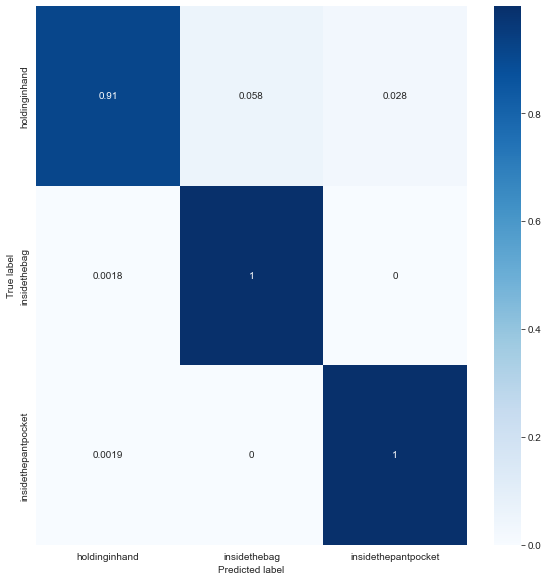

In [112]:
from sklearn.metrics import classification_report
import seaborn as sns

# EVALUATION
model = models.load_model("logs/2022-06-21/id_33/model.h5")

log_writer = LogWriter(enabled=False)
test_loss, test_acc = model.evaluate(test_x, test_y_context)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)
metrics_report = classification_report(test_y_context, y_pred)
print("Metrics report: ")
print(metrics_report)

con_mat = tf.math.confusion_matrix(labels=test_y_context, predictions=y_pred).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()

log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.write("Metric report: ")
log_writer.write(metrics_report)
log_writer.close()

## Final Evaluation

In [126]:
print(location_labels)

['holdinginhand', 'insidethebag', 'insidethepantpocket']


In [148]:
from keras import models

print(location_labels)


def evaluate(context_model, bag_model, pant_model, hand_model):
    context_prediction = context_model.predict(test_x)
    context_prediction = np.argmax(context_prediction, axis=1)

    result = []
    for i in range(len(test_x)):
        print("Evaluating item " + str(i + 1) + "/" + str(len(test_x)))
        predicted_context_index = context_prediction[i]
        if location_labels[predicted_context_index] == 'holdinginhand':
            step_prediction = hand_model.predict(test_x[i:i + 1])[0][0]
        elif location_labels[predicted_context_index] == 'insidethebag':
            step_prediction = bag_model.predict(test_x[i:i + 1])[0][0]
        elif location_labels[predicted_context_index] == 'insidethepantpocket':
            step_prediction = pant_model.predict(test_x[i:i + 1])[0][0]
        else:
            raise Exception("Invalid index")
        result.append(step_prediction)
    return np.array(context_prediction), np.array(result)


context_predictions, step_predictions = evaluate(
    context_model=models.load_model("logs/2022-06-21/id_33/model.h5"),
    bag_model=models.load_model("logs/2022-06-21/id_8/model.h5"),
    pant_model=models.load_model("logs/2022-06-21/id_3/model.h5"),
    hand_model=models.load_model("logs/2022-06-21/id_15/model.h5")
)

['holdinginhand', 'insidethebag', 'insidethepantpocket']
Evaluating item 1/1626
Evaluating item 2/1626
Evaluating item 3/1626
Evaluating item 4/1626
Evaluating item 5/1626
Evaluating item 6/1626
Evaluating item 7/1626
Evaluating item 8/1626
Evaluating item 9/1626
Evaluating item 10/1626
Evaluating item 11/1626
Evaluating item 12/1626
Evaluating item 13/1626
Evaluating item 14/1626
Evaluating item 15/1626
Evaluating item 16/1626
Evaluating item 17/1626
Evaluating item 18/1626
Evaluating item 19/1626
Evaluating item 20/1626
Evaluating item 21/1626
Evaluating item 22/1626
Evaluating item 23/1626
Evaluating item 24/1626
Evaluating item 25/1626
Evaluating item 26/1626
Evaluating item 27/1626
Evaluating item 28/1626
Evaluating item 29/1626
Evaluating item 30/1626
Evaluating item 31/1626
Evaluating item 32/1626
Evaluating item 33/1626
Evaluating item 34/1626
Evaluating item 35/1626
Evaluating item 36/1626
Evaluating item 37/1626
Evaluating item 38/1626
Evaluating item 39/1626
Evaluating item 

In [156]:
class PredictionProfile:

    def __init__(self, context_correct, step_count_correct, context):
        self.context_correct = context_correct
        self.step_count_correct = step_count_correct
        self.context = context

In [157]:
correct_count = 0
diff_list = []
rounded_step_predictions = [round(i) for i in step_predictions]
prediction_profile_list = []

for i in range(len(test_y_step)):
    is_step_count_correct = test_y_step[i] == rounded_step_predictions[i]
    prediction_profile_list.append(PredictionProfile(
        context_correct=context_predictions[i] == test_y_context[i],
        context=test_y_context[i],
        step_count_correct=is_step_count_correct
    ))
    diff_list.append(abs(test_y_step[i] - step_predictions[i]))
    if is_step_count_correct:
        correct_count += 1
    # else:
    #     print("Incorrect: index - ", i, " | base - ", test_y_step[i], " | actual - ", step_predictions[i])
print("Correct: ", correct_count, "/", len(step_predictions))
print(sum(diff_list) / len(diff_list))

Correct:  1235 / 1626
0.41808024858929865


In [160]:
holding_in_hand_list = [profile for profile in prediction_profile_list if profile.context == 0]
bag_list = [profile for profile in prediction_profile_list if profile.context == 1]
pant_list = [profile for profile in prediction_profile_list if profile.context == 2]

print("Hand list length: ", str(len(holding_in_hand_list)))
print("Bag list length: ", str(len(bag_list)))
print("Pant list: ", str(len(pant_list)))

Hand list length:  565
Bag list length:  544
Pant list:  517


In [163]:
def print_list_result(list_name, list):
    print("**************************\nShowing result for list " + list_name)
    y_context_y_step = 0
    y_context_n_step = 0
    n_context_y_step = 0
    n_context_n_step = 0

    for profile in list:
        if profile.context_correct and profile.step_count_correct:
            y_context_y_step += 1
        elif profile.context_correct and not profile.step_count_correct:
            y_context_n_step += 1
        elif not profile.context_correct and profile.step_count_correct:
            n_context_y_step += 1
        else:
            n_context_n_step += 1
    print(y_context_y_step, y_context_n_step,n_context_y_step,n_context_n_step)
    print("Success rate ", (y_context_y_step + n_context_y_step) / (y_context_y_step + y_context_n_step + n_context_y_step + n_context_n_step))

print_list_result("Holding in hand", holding_in_hand_list)
print_list_result("Inside the bag", bag_list)
print_list_result("Inside the pant", pant_list)

**************************
Showing result for list Holding in hand
388 128 35 14
Success rate  0.7486725663716814
**************************
Showing result for list Inside the bag
405 138 0 1
Success rate  0.7444852941176471
**************************
Showing result for list Inside the pant
407 109 0 1
Success rate  0.7872340425531915
